# 7 - TensorFlow CNN with Aleatoric Uncertainty

We've seen how easy it is to train a convolutional neural network in TensorFlow 2.0 `keras`, but let's now try to add on some aleatoric uncertainty by having that CNN parameterize a probability distribution, rather than directly trying to guess the output "probabilities".

In [77]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_probability as tfp

print(tf.__version__)
tf.get_logger().setLevel('ERROR')

2.0.0


For this exercise, we'll focus again on the CIFAR-10 data set.

In [78]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

To simplify things, we'll limit the classification task to just two classes - birds and planes.

In [79]:
chosen_labels = [0, 2]

train_images = np.array(train_images[[i for (i, label) in enumerate(train_labels) if label in chosen_labels]])
train_labels = np.array([label for label in train_labels if label in chosen_labels]) // 2
test_images = np.array(test_images[[i for (i, label) in enumerate(test_labels) if label in chosen_labels]])
test_labels = np.array([label for label in test_labels if label in chosen_labels]) // 2

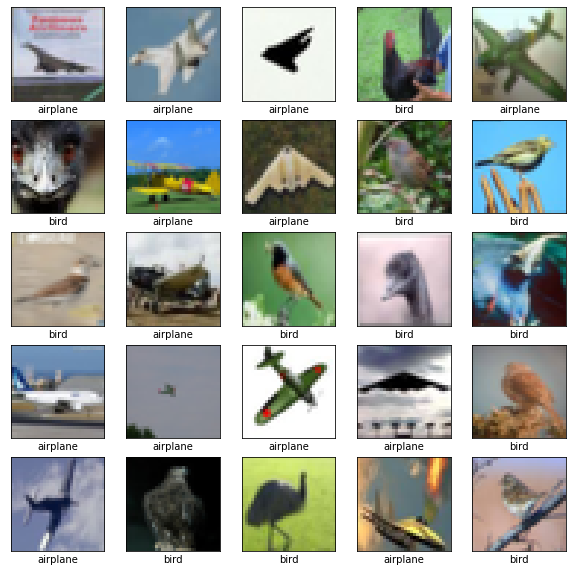

In [80]:
class_names = ['airplane', 'bird']

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[test_labels[i][0]])
plt.show()

### It's a bird, it's a plane...

We'll start by building our convolutional network as before.

In [81]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [82]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


Now, though, instead of outputting a final `layers.Dense(10, activation='softmax')`, we'll instead scale the number of outputs down to the number of parameters a probability distribution needs in order to describe our new number of classes (2). Fortunately, TensorFlow Probability comes with such a helper function.

In [83]:
tfp.layers.IndependentBernoulli(200).params_size()

1

We're using the Bernoulli distribution (sometimes called the coin-flip distribution) in order to describe predictions of our two classes. You probably already knew that the Bernoulli distribution takes a single parameter, but TFP saw fit to remind us anyway.

In [84]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))
model.add(
    tfp.layers.DistributionLambda(
        lambda t: tfp.distributions.Bernoulli(logits=t)
    )
)

In [85]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

Note that, because our dense layer lost 9 of its activations, we actually have _fewer_ trainable parameters to learn. The Bernoulli distribution at the end doesn't wind up costing anything in parameter space -- it only consumes the outputs of other layers.

Let's get to training.

In [86]:
checkpoint_path = 'saved_models/aleatoric_cnn.ckpt'

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              loss=lambda y, p_y: -p_y.log_prob(y),  # Use the negative-log likelihood directly as the model loss.
              metrics=['accuracy'])

In [87]:
# # Run this cell to train the model from scratch.

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

# history = model.fit(train_images, train_labels, epochs=20, 
#                     validation_data=(test_images, test_labels), callbacks=[cp_callback])

# history_dict = history.history

# with open(os.path.join(os.getcwd(), 'saved_models', 'aleatoric_cnn_history.pkl'), 'wb') as file:
#     pickle.dump(history_dict, file)

In [88]:
# Run this cell instead to load pre-trained model weights
model.load_weights(checkpoint_path)

with open(os.path.join(os.getcwd(), 'saved_models', 'aleatoric_cnn_history.pkl'), 'rb') as file:
    history_dict = pickle.load(file)

2000/1 - 1s - loss: 0.6163 - accuracy: 0.8795


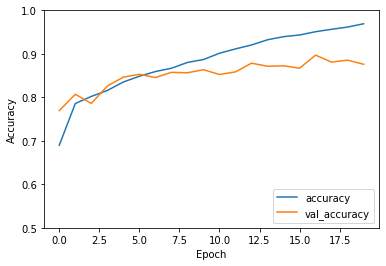

In [89]:
plt.plot(history_dict['accuracy'], label='accuracy')
plt.plot(history_dict['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

So a bit overfitting going on here -- remember, we didn't allow for uncertainty over the model weights, only in the nature of the data.

In [90]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

2000/1 - 0s - loss: 0.6163 - accuracy: 0.8835


Our first image in the test set is a plane (label zero) -- let's see if we got it.

In [91]:
model.predict(test_images[0:1])

array([[0]], dtype=int32)

It looks like it. That extra index in the numpy array is kind of annoying -- we can clean it up with `np.squeeze()` and `np.ndarray.tolist()`

The third image was a plane, but it looked a lot like it could be a bird. How was that one?

Recall that our model is actually passing a distribution whenever it is called on an input image. Let's use the distribution directly to answer our question.

In [92]:
third_prediction = model(test_images[2:3]).sample(1000).numpy().squeeze()

In [93]:
third_prediction

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,

In [94]:
third_prediction.mean()

0.337

The model is quite uncertain, which means that it's picked up on the fact that it's a fuzzy image that could potentially go either way.

## Examining uncertainty up-close

From a high number of samples, an input image that causes a low mean prediction will have a high probability of being classified as a plane, and an image that causes a high mean prediction will have a high probability of being classified as a bird.

Let's find the images that are most in the middle. These would be the inputs that the model is most uncertain about from an aleatoric standpoint -- it hasn't been able to learn features that would distinguish this image consistently. Following our intuition about high and low mean outputs, we should want the input images that have a mean close to 0.5. We can highlight these by subtracting 0.5 from all means, taking the absolute value, and finding the minimum entry.

This cell takes about 20 seconds to run.

In [95]:
n_samples = 1_000

preds = [abs(pd.DataFrame(model(test_images[i:i + 1]).sample(n_samples).numpy().squeeze()).mean() - 0.5) 
         for i in range(len(test_images))]

In [96]:
preds[0:10]

[0    0.392
 dtype: float64, 0    0.085
 dtype: float64, 0    0.17
 dtype: float64, 0    0.498
 dtype: float64, 0    0.499
 dtype: float64, 0    0.499
 dtype: float64, 0    0.427
 dtype: float64, 0    0.5
 dtype: float64, 0    0.5
 dtype: float64, 0    0.219
 dtype: float64]

In [97]:
min_ind = np.array(preds).argmin()

Let's take a look at sample model predictions for this minimum index. Remember, we're interested in finding images that have a roughly equal number of zeros ane ones in their sample predicted outputs.

In [98]:
model(test_images[min_ind:min_ind+1]).sample(1000).numpy().squeeze()

array([1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,

In [99]:
model(test_images[min_ind:min_ind+1]).sample(1000).numpy().squeeze().mean()

0.482

Excellent! This image is almost right in between the two classes.

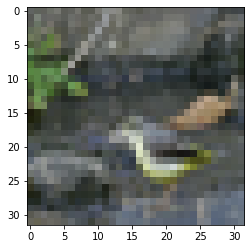

In [100]:
plt.imshow(test_images[min_ind], cmap=plt.cm.binary)

## Throwing a wrench in the plan

We've seen that the aleatoric model successfully conveys uncertainty for images that could either be classified as a bird or a plane. How does it do for an image that isn't either?

In [30]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

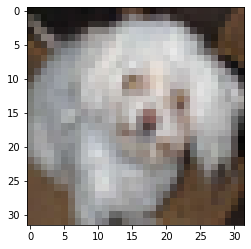

In [31]:
plt.imshow(test_images[1000], cmap=plt.cm.binary)

In [32]:
model(test_images[1000:1001]).sample(1000).numpy().squeeze()

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Apparently, our model is certain that this puppy is a bird. This is an important point -- aleatoric uncertainty doesn't allow us to convey uncertainty about data far away from what the model has trained on; it only lets a model indicate the variance present in the data itself. In this case, it does nothing to protect us from foreign image classes.

## Takeaways

- Aleatoric uncertainty can be expressed in any model by directing an output layer to parameterize a distribution describing predictions for an input, rather than predicting the input directly.
- TensorFlow Probability lets us do this cleanly and transparently with the `DistributionLambda` layer and the `params_size` helper methods.
- Aleatoric uncertainty can uncover edge case inputs that are probabilistically very difficult to predict accuracy with confidence.
- Aleatoric uncertainty does _not_ help us guard against inputs outside the context a model was trained on.